# Algotrading prototyping notebook

### Important info

Alpha Vantage API key: DK3F3HB19R3IX4C3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# only run this cell if you want to (refresh) download new data
from alpha_vantage.foreignexchange import ForeignExchange
fx = ForeignExchange(key='YOUR_API_KEY', output_format='pandas')
eurusd, meta = fx.get_currency_exchange_daily(from_symbol='EUR', to_symbol='USD', outputsize='full')
eurusd.to_csv('/Users/danieltompkins/Documents/Algotrading_project/Data/EURUSD_180525.csv')

In [2]:
# Load the CSV into a DataFrame
eurusd = pd.read_csv('/Users/danieltompkins/Documents/Algotrading_project/Data/EURUSD_180525.csv', index_col=0, parse_dates=True)

# Optional: rename columns for simplicity
eurusd.columns = ['open', 'high', 'low', 'close']


# Optional: sort ascending (older dates first)
eurusd = eurusd.sort_index()

In [3]:
eurusd.head()

,open,high,low,close
date,,,,
2006-03-17,1.2182,1.2207,1.2139,1.2195
2006-03-20,1.2168,1.2196,1.2147,1.2165
2006-03-21,1.2154,1.2171,1.2074,1.2092
2006-03-22,1.2094,1.2114,1.2062,1.2074
2006-03-23,1.2075,1.2081,1.1953,1.1967


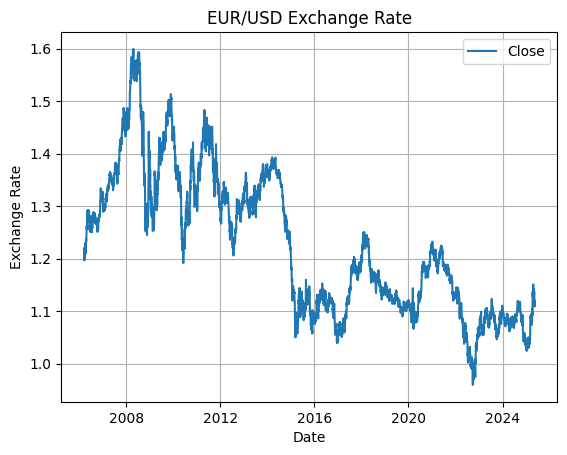

In [4]:
plt.plot(eurusd['close'], label='Close')
plt.title('EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()